In [1]:
#import all we need for now
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import json
import os

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/automatic-plant-cell-detection/Vessel Detection.v1i.coco (1)/README.dataset.txt
/kaggle/input/automatic-plant-cell-detection/Vessel Detection.v1i.coco (1)/README.roboflow.txt
/kaggle/input/automatic-plant-cell-detection/Vessel Detection.v1i.coco (1)/valid/Ccr-2-stem-19_png.rf.2a394b91faf9bd5c22f2de21c83e1fe4.jpg
/kaggle/input/automatic-plant-cell-detection/Vessel Detection.v1i.coco (1)/valid/Rca-1-stem-15_png.rf.64732016056cb78e7c5a6c814cdb7b18.jpg
/kaggle/input/automatic-plant-cell-detection/Vessel Detection.v1i.coco (1)/valid/Rca-2-stem-11_png.rf.4f18509868de74ba2f96c4befa7e0d84.jpg
/kaggle/input/automatic-plant-cell-detection/Vessel Detection.v1i.coco (1)/valid/Ccr-1-stem-4_png.rf.d6d267299d7cdd4316db3a254ba493d0.jpg
/kaggle/input/automatic-plant-cell-detection/Vessel Detection.v1i.coco (1)/valid/Ccr-3-stem-2_png.rf.ff1590e493333217eca7def67e61ce68.jpg
/kaggle/input/automatic-plant-cell-detection/Vessel Detection.v1i.coco (1)/valid/Co-1-stem-6_png.rf.e292926a8d04d2f112

In [3]:
#folder and annotations are provided from me
image_dir = '/kaggle/input/automatic-plant-cell-detection/Vessel Detection.v1i.coco (1)/train'
annotations_file = '/kaggle/input/automatic-plant-cell-detection/Vessel Detection.v1i.coco (1)/train/_annotations.coco.json'

#class of the dataset
class CustomCocoDataset(Dataset):

    #initialize cocoDataset
    def __init__(self, image_dir, annotation_file, transforms=None):
        self.image_dir = image_dir
        self.transforms = transforms

        with open(annotation_file, 'r') as f:
            self.coco_data = json.load(f)

        self.images = self.coco_data['images']
        self.annotations = self.coco_data['annotations']
        self.categories = self.coco_data['categories']

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image_info = self.images[idx]
        img_path = os.path.join(self.image_dir, image_info['file_name'])
        img = Image.open(img_path).convert("RGB")

        ann_ids = [ann for ann in self.annotations if ann['image_id'] == image_info['id']]

        boxes = []
        labels = []

        for ann in ann_ids:
            bbox = ann['bbox']
            # Convert bbox format from [x,y,width,height] to [x_min, y_min, x_max, y_max]
            xmin = bbox[0]
            ymin = bbox[1]
            xmax = bbox[0] + bbox[2]
            ymax = bbox[1] + bbox[3]
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(ann['category_id'] + 1)  # Start labels from 1 (background is 0 therefore the vessel should be 1)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        if self.transforms:
            img = self.transforms(img)

        return img, target


transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = CustomCocoDataset(image_dir, annotations_file, transforms=transform)
data_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))


print(dataset.__getitem__(0))

(tensor([[[0.7255, 0.7373, 0.7608,  ..., 0.7804, 0.7961, 0.8039],
         [0.7216, 0.7333, 0.7529,  ..., 0.7804, 0.7922, 0.7961],
         [0.7098, 0.7255, 0.7451,  ..., 0.7961, 0.8000, 0.7961],
         ...,
         [0.9176, 0.9216, 0.9333,  ..., 0.7373, 0.7137, 0.6902],
         [0.9020, 0.9176, 0.9412,  ..., 0.6980, 0.6784, 0.6588],
         [0.8941, 0.9176, 0.9490,  ..., 0.6784, 0.6745, 0.6667]],

        [[0.8471, 0.8588, 0.8667,  ..., 0.7922, 0.8157, 0.8235],
         [0.8392, 0.8549, 0.8627,  ..., 0.7922, 0.8118, 0.8157],
         [0.8353, 0.8431, 0.8549,  ..., 0.8078, 0.8157, 0.8235],
         ...,
         [0.8471, 0.8510, 0.8627,  ..., 0.7059, 0.6706, 0.6471],
         [0.8314, 0.8471, 0.8706,  ..., 0.6706, 0.6431, 0.6235],
         [0.8235, 0.8471, 0.8784,  ..., 0.6510, 0.6392, 0.6314]],

        [[0.7882, 0.8000, 0.8078,  ..., 0.4824, 0.4941, 0.5020],
         [0.7922, 0.7961, 0.8078,  ..., 0.4824, 0.4980, 0.5020],
         [0.7922, 0.7961, 0.8000,  ..., 0.5059, 0.5137, 0

In [4]:
# Load model

num_classes = len(dataset.categories) + 1
model = fasterrcnn_resnet50_fpn(pretrained=True)


# Properly redefine the box predictor
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) #the pre-trained fasterrcnn is on coco (91 classes) we need to adapt to 2 classes

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 195MB/s]


cuda


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

Parameters for optimizing

In [5]:
params = [p for p in model.parameters() if p.requires_grad]  #in the pre-trained model allow certain parameters to be optimized
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
#weight decay helps deal with overfitting, regularization prevents large weights I beieve

# Learning rate scheduler
#every 3 steps reduce LR by magnitude of 10
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Training loop

In [6]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        running_loss += losses.item()

        optimizer.zero_grad()

        losses.backward()
        optimizer.step()

    # Step the learning rate scheduler
    lr_scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(data_loader)}")



Epoch 1/10, Loss: 0.9777260224024454
Epoch 2/10, Loss: 0.620896632472674
Epoch 3/10, Loss: 0.5486402842733595
Epoch 4/10, Loss: 0.5080936186843448
Epoch 5/10, Loss: 0.48075244824091595
Epoch 6/10, Loss: 0.4710032617052396
Epoch 7/10, Loss: 0.46402279039223987
Epoch 8/10, Loss: 0.4642564141088062
Epoch 9/10, Loss: 0.4613467968172497
Epoch 10/10, Loss: 0.46178630656666225


In [7]:
# Save model
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn_custom.pth')

# Load model
model.load_state_dict(torch.load('fasterrcnn_resnet50_fpn_custom.pth'))
model.eval()

<ipython-input-7-ba64a44ec606>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('fasterrcnn_resnet50_fpn_custom.pth'))


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

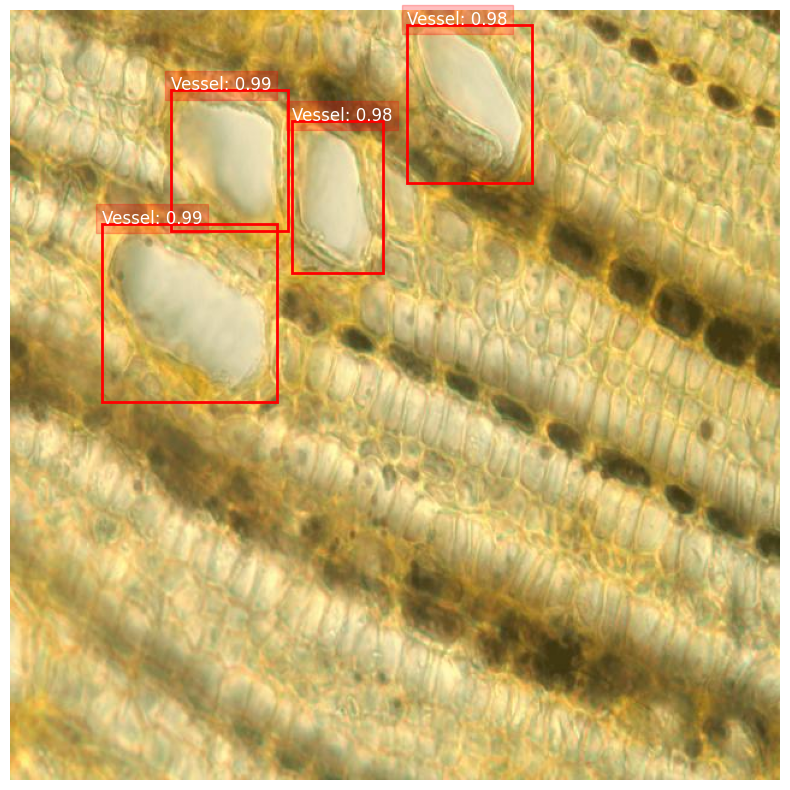

'\nfor img in os.listdir(test_folder):\n    predictions = predict(img, model, device)\n    display_prediction(img, predictions)\n    print(img)\n\n'

In [8]:
def predict(image_path, model, device):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([transforms.ToTensor()])
    image = transform(image).to(device)
    model.eval()
    with torch.no_grad():
        prediction = model([image])

    return prediction

#predict one image path
image_path = '/kaggle/input/automatic-plant-cell-detection/Vessel Detection.v1i.coco (1)/test/Co-2-stem-1_png.rf.6797c19c7c90cf2adafc15f1edd291f7.jpg'
predictions = predict(image_path, model, device)

def display_prediction(image_path, predictions, threshold=0.5):
    image = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(10,10))
    plt.imshow(image)

    prediction = predictions[0]
    boxes = prediction['boxes'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()
    labels = prediction['labels'].cpu().numpy()

    for box, score, label in zip(boxes, scores, labels):
        if score > threshold:
            xmin, ymin, xmax, ymax = box
            plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                                              linewidth=2, edgecolor='red', facecolor='none'))
            text = plt.text(xmin, ymin, f"{dataset.categories[label-1]['name']}: {score:.2f}",
                     color='white', fontsize=12, backgroundcolor='red')
            text.set_bbox(dict(facecolor='red', alpha=0.25, edgecolor='red'))

    plt.axis('off')
    plt.show()

def prediction_boxes(predictions):
    prediction = predictions[0]
    boxes = prediction['boxes'].cpu().numpy()
    return boxes

display_prediction(image_path, predictions)
# Display the predictions

    
'''
for img in os.listdir(test_folder):
    predictions = predict(img, model, device)
    display_prediction(img, predictions)
    print(img)

'''    

In [9]:
#predict all images
import pandas as pd
test_folder = '/kaggle/input/automatic-plant-cell-detection/Vessel Detection.v1i.coco (1)/test/'


#i dont know why i did it this way to get the data but its ok it works
ID = []
FileName = []
new_boxes = []
categoryIDs = []

idCount = 0

for img in os.listdir(test_folder):
    newimg = '/kaggle/input/automatic-plant-cell-detection/Vessel Detection.v1i.coco (1)/test/' + img
    print(newimg)
    predictions = predict(newimg, model, device)
    #display_prediction(img, predictions)
    newbox = prediction_boxes(predictions)

    #making the row for an individual image
    newID = []
    for num in newbox:
        newID.append(1)
    new_boxes.append(newbox)
    categoryIDs.append(newID)
    ID.append(idCount)
    FileName.append(img)
    idCount += 1


    #print(newID)
    #print(newbox)
    


#print(categoryIDs)
#print(new_boxes)
submission = pd.DataFrame({'ID':ID, 'FileName':FileName,'BoundingBoxes': new_boxes,'CategoryIDs' : categoryIDs,'Usage':'Public'})


print(submission)
submission.to_csv('submission.csv',index=False)

print("Submission successfully saved!")






/kaggle/input/automatic-plant-cell-detection/Vessel Detection.v1i.coco (1)/test/Co-2-stem-1_png.rf.6797c19c7c90cf2adafc15f1edd291f7.jpg
/kaggle/input/automatic-plant-cell-detection/Vessel Detection.v1i.coco (1)/test/Co-1-root-5_png.rf.04fe6681c9775758c76bbfbbe965cb9c.jpg
/kaggle/input/automatic-plant-cell-detection/Vessel Detection.v1i.coco (1)/test/Rca-1-stem-5_png.rf.96f6b2e78b93061fbfef6fa8641ba657.jpg
/kaggle/input/automatic-plant-cell-detection/Vessel Detection.v1i.coco (1)/test/Rca-3-root-4_png.rf.74dded54411abd9662fb24801b74fb1f.jpg
/kaggle/input/automatic-plant-cell-detection/Vessel Detection.v1i.coco (1)/test/Co-3-stem-16_png.rf.aeb57797138101605ff72c1153a7a57d.jpg
/kaggle/input/automatic-plant-cell-detection/Vessel Detection.v1i.coco (1)/test/Rca-2-root-11_png.rf.d4a7247a11be8165a6a1fa8a2fbb2c21.jpg
/kaggle/input/automatic-plant-cell-detection/Vessel Detection.v1i.coco (1)/test/Ccr-1-root-5_png.rf.3891ea52467abfd4a9601d9d141bc71c.jpg
/kaggle/input/automatic-plant-cell-detecti